# 2D QLIPP reconstruction with experimental data
This reconstruction is based on the QLIPP paper ([here](https://elifesciences.org/articles/55502)): <br>
``` S.-M. Guo, L.-H. Yeh, J. Folkesson, I. E. Ivanov, A. P. Krishnan, M. G. Keefe, E. Hashemi, D. Shin, B. B. Chhun, N. H. Cho, M. D. Leonetti, M. H. Han, T. J. Nowakowski, S. B. Mehta , "Revealing architectural order with quantitative label-free imaging and deep learning," eLife 9:e55502 (2020).```

In [27]:
import glob

import matplotlib.pyplot as plt
import numpy as np
from skimage import io

import waveorder as wo

%matplotlib inline
plt.style.use(["dark_background"])  # Plotting option for dark background

### Experiment parameters

In [2]:
n_media = 1  # refractive index of the immersed media for objective (oil: 1.512, water: 1.33, air: 1)
lambda_illu = 0.532  # illumination wavelength (um)
mag = 20  # magnification of the microscope
NA_obj = 0.55  # detection NA of the objective
NA_illu = 0.4  # illumination NA of the condenser
N_defocus = 21  # number of defocus images
N_channel = 5  # number of Polscope channels
z_step = 1.3  # z_step of the stack
z_defocus = -(np.r_[:N_defocus] - 10) * z_step
chi = 0.1 * 2 * np.pi  # swing of the LC
ps = 6.45 / mag  # effective pixel size at the sample plane (cam pix/mag in um)
cali = True  # correction for S1/S2 Polscope reconstruction (does not affect phase)
bg_option = "global"  # background correction method for Polscope recon (does not affect phase)
data_path = "/gpfs/CompMicro/rawdata/hummingbird/LiHao/20190829_Kazansky_BF/SMS_2019_0829_1639_1/Pos0/"  # data path
bg_path = (
    "/gpfs/CompMicro/rawdata/hummingbird/LiHao/20190829_Kazansky_BF/BG_2019_0829_1638_1/Pos0/"  # background data path
)
use_gpu = True
gpu_id = 2

In [3]:
filedir = data_path + "*State*.tif"
filedir_bg = bg_path + "*State*.tif"
files = sorted(glob.glob(filedir), key=wo.numericalSort)
files_bg = sorted(glob.glob(filedir_bg), key=wo.numericalSort)

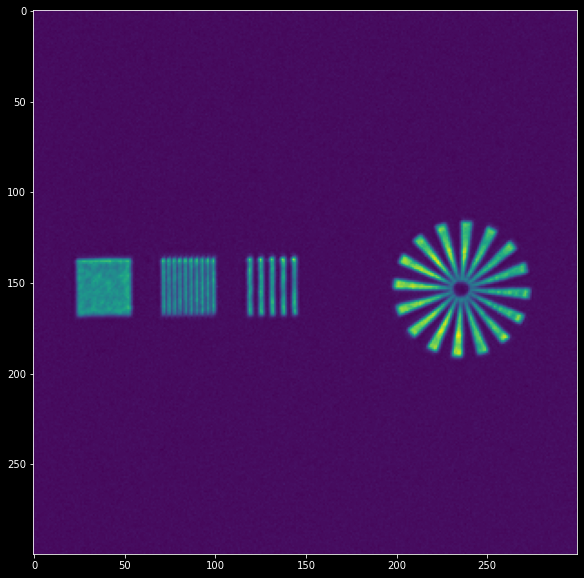

In [4]:
# select a FOV for processing

Ns = 300
Ms = 300
n_start = [820, 890]


plt.figure(figsize=(10, 10))
plt.imshow(plt.imread(files[10]).astype("float64")[n_start[0] : n_start[0] + Ns, n_start[1] : n_start[1] + Ms])

### Load data

In [5]:
# Load files

Nimg = N_defocus * N_channel

# Load background images
Nbg = len(files_bg)
I_bg_pre = []

for i in range(0, Nbg):
    Itemp = io.imread(files_bg[i]).astype("float64")[n_start[0] : n_start[0] + Ns, n_start[1] : n_start[1] + Ms]
    I_bg_pre.append(Itemp)

I_bg_pre = np.array(I_bg_pre)
I_bg = wo.intensity_mapping(I_bg_pre)

I_meas_pre = []

for i in range(0, Nimg):
    Itemp = io.imread(files[i]).astype("float64")[n_start[0] : n_start[0] + Ns, n_start[1] : n_start[1] + Ms]
    I_meas_pre.append(Itemp)

I_meas_pre = np.array(I_meas_pre)
I_meas_pre = np.transpose(I_meas_pre.reshape((N_channel, N_defocus, Ns, Ms)), (0, 2, 3, 1))

# intensity mapping to match the theory
I_meas = np.zeros_like(I_meas_pre)
for i in range(N_defocus):
    I_meas[:, :, :, i] = wo.intensity_mapping(I_meas_pre[:, :, :, i])

### Polarization reconstruction

In [28]:
# Reconstruct parameters


setup = wo.waveorder_microscopy(
    (Ns, Ms),
    lambda_illu,
    ps,
    NA_obj,
    NA_illu,
    z_defocus,
    chi,
    n_media=n_media,
    cali=cali,
    bg_option=bg_option,
    illu_mode="BF",
    phase_deconv="2D",
    bire_in_plane_deconv="2D",
    use_gpu=use_gpu,
    gpu_id=gpu_id,
)

In [29]:
S_image_recon = setup.Stokes_recon(I_meas)
S_bg_recon = setup.Stokes_recon(I_bg)
S_image_tm = setup.Stokes_transform(S_image_recon)
S_bg_tm = setup.Stokes_transform(S_bg_recon)
S_image_tm = setup.Polscope_bg_correction(S_image_tm, S_bg_tm)
Recon_para = setup.Polarization_recon(S_image_tm)

In [30]:
wo.parallel_4D_viewer(np.transpose(I_meas[:, 105:205, 185:285], (3, 0, 1, 2)), num_col=2, size=10)

interactive(children=(IntSlider(value=0, description='stack_idx', max=20), Output()), _dom_classes=('widget-in…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [31]:
wo.parallel_4D_viewer(np.transpose(S_image_recon[:, 105:205, 185:285], (3, 0, 1, 2)), num_col=2, size=10)

interactive(children=(IntSlider(value=0, description='stack_idx', max=20), Output()), _dom_classes=('widget-in…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [32]:
wo.parallel_4D_viewer(np.transpose(Recon_para[:, 105:205, 185:285], (3, 0, 1, 2)), num_col=2, size=10)

interactive(children=(IntSlider(value=0, description='stack_idx', max=20), Output()), _dom_classes=('widget-in…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

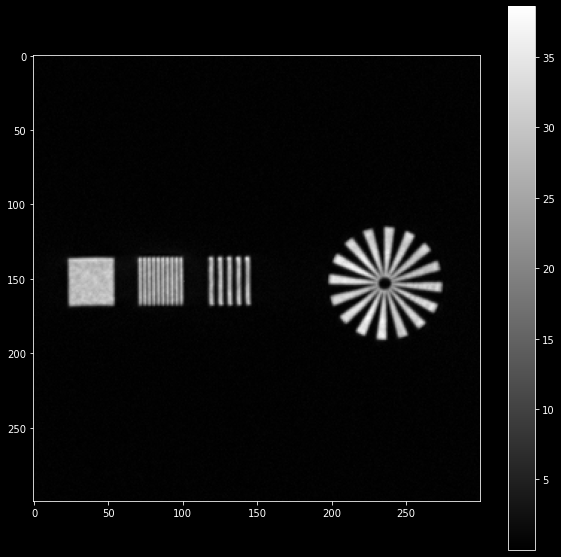

In [33]:
plt.figure(figsize=(10, 10))
plt.imshow(Recon_para[0, :, :, 10] / 2 / np.pi * lambda_illu * 1e3, cmap="gray")
plt.colorbar()

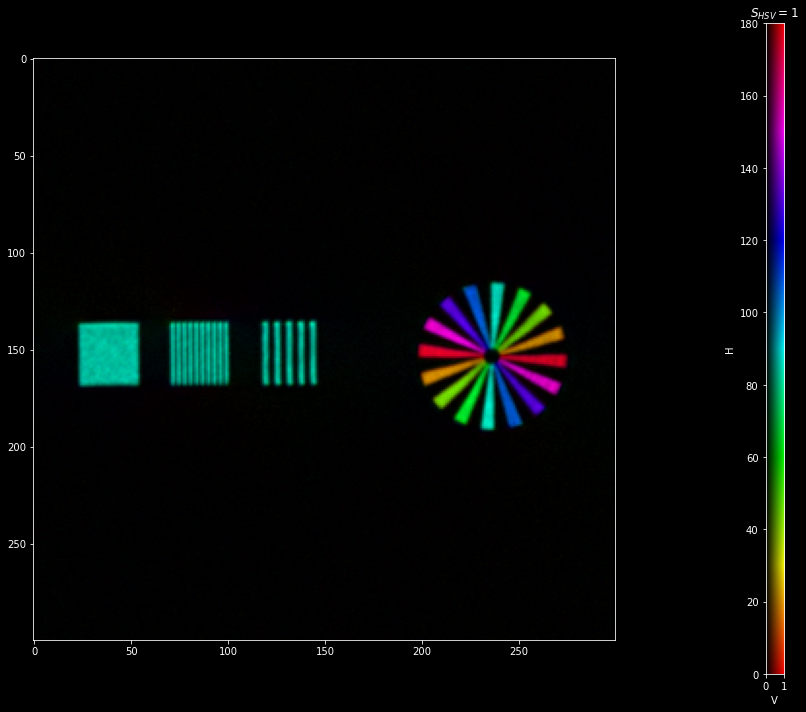

In [34]:
wo.plot_hsv([Recon_para[1, :, :, 10], Recon_para[0, :, :, 10]], max_val=1, size=10)

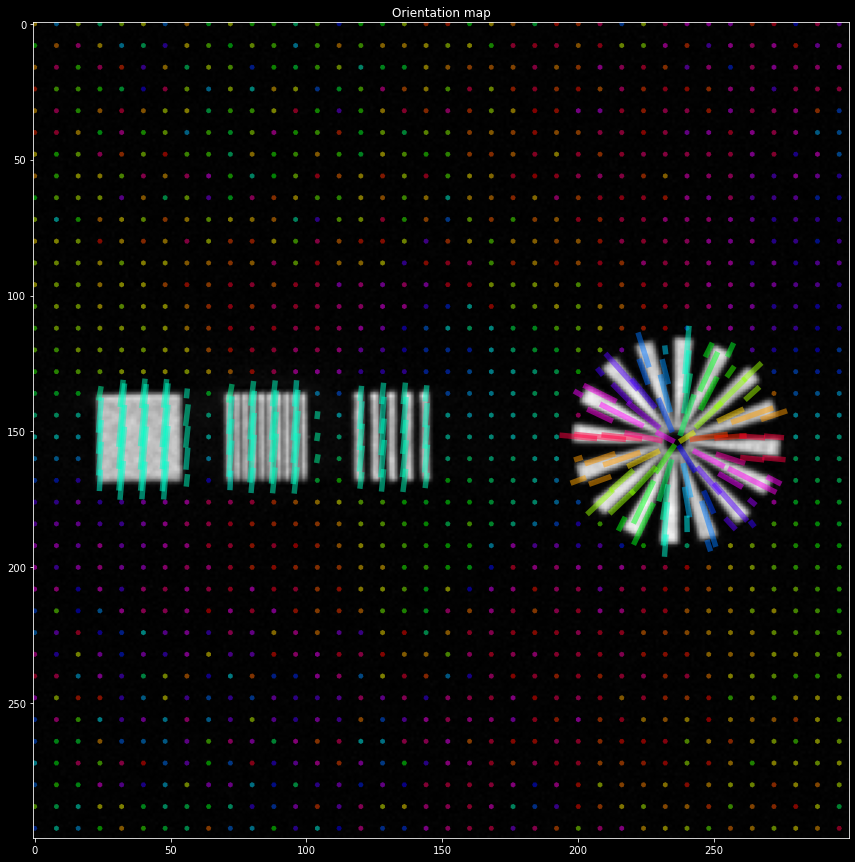

In [35]:
spacing = 8

plt.figure(figsize=(15, 15))
wo.plotVectorField(
    Recon_para[0, :, :, 10],
    Recon_para[1, :, :, 10],
    anisotropy=Recon_para[0, :, :, 10] / np.max(Recon_para[0, :, :, 10]) * 0.5,
    spacing=spacing,
    window=spacing,
    linelength=spacing,
    linewidth=2,
    linecolor="y",
    colorOrient=True,
    cmapOrient="hsv",
    threshold=None,
    alpha=0.5,
    clim=[None, None],
    cmapImage="gray",
)

In [36]:
import gc

import cupy as cp

gc.collect()
cp.get_default_memory_pool().free_all_blocks()

### Phase reconstruction

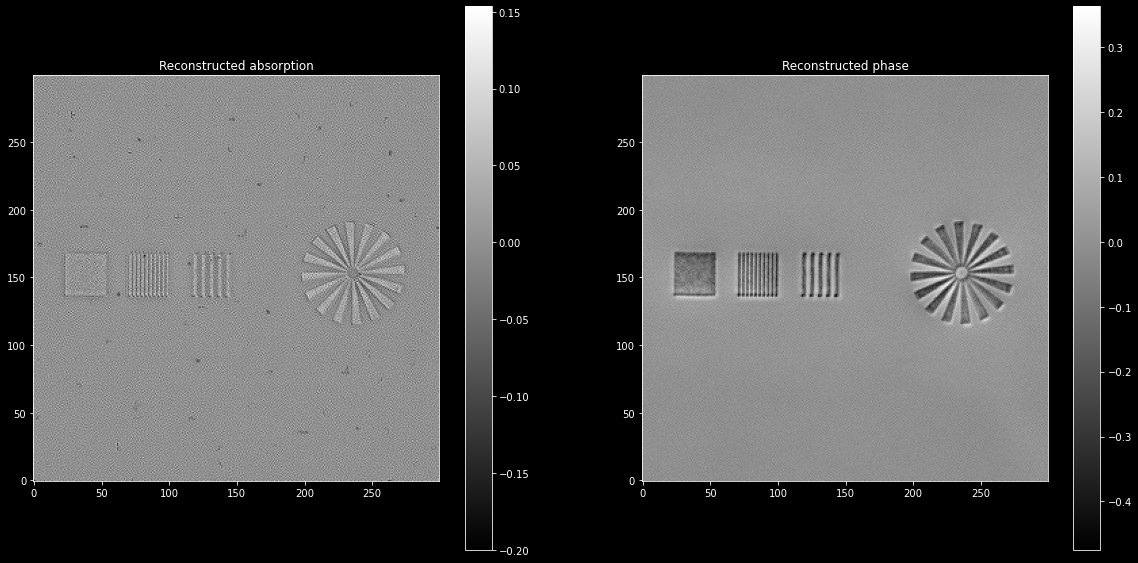

In [37]:
# Tikhonov regularizer
reg_u = 1e-3
reg_p = 1e-3
S0_stack = S_image_recon[0].copy()

mu_sample, phi_sample = setup.Phase_recon(S0_stack, method="Tikhonov", reg_u=reg_u, reg_p=reg_p)

wo.plot_multicolumn(
    np.array([mu_sample, phi_sample]),
    num_col=2,
    size=10,
    set_title=True,
    titles=["Reconstructed absorption", "Reconstructed phase"],
    origin="lower",
)

Number of iteration computed (1 / 50)
Number of iteration computed (2 / 50)
Number of iteration computed (3 / 50)
Number of iteration computed (4 / 50)
Number of iteration computed (5 / 50)
Number of iteration computed (6 / 50)
Number of iteration computed (7 / 50)
Number of iteration computed (8 / 50)
Number of iteration computed (9 / 50)
Number of iteration computed (10 / 50)
Number of iteration computed (11 / 50)
Number of iteration computed (12 / 50)
Number of iteration computed (13 / 50)
Number of iteration computed (14 / 50)
Number of iteration computed (15 / 50)
Number of iteration computed (16 / 50)
Number of iteration computed (17 / 50)
Number of iteration computed (18 / 50)
Number of iteration computed (19 / 50)
Number of iteration computed (20 / 50)
Number of iteration computed (21 / 50)
Number of iteration computed (22 / 50)
Number of iteration computed (23 / 50)
Number of iteration computed (24 / 50)
Number of iteration computed (25 / 50)
Number of iteration computed (26 /

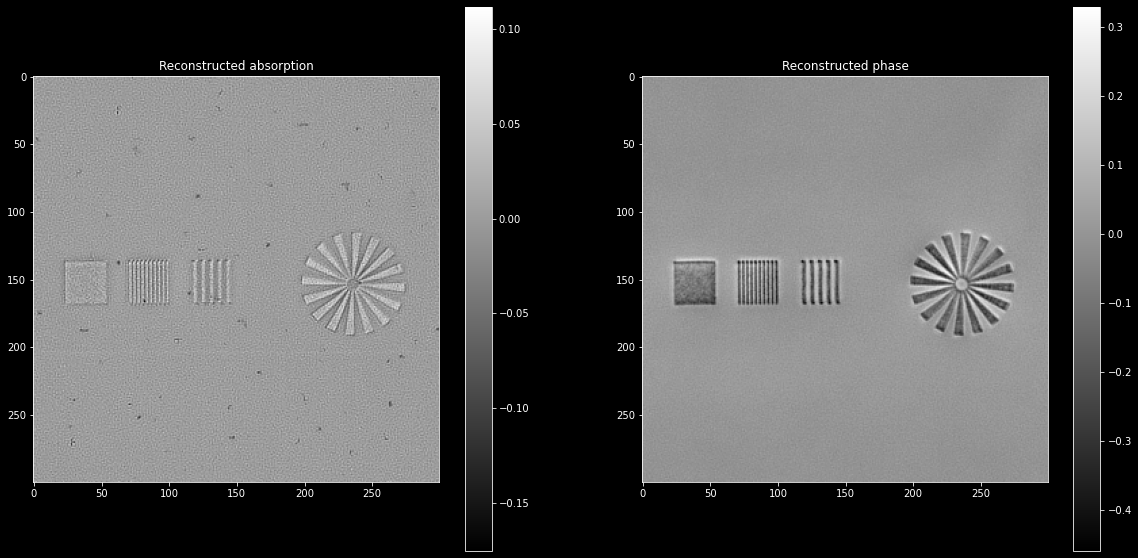

In [38]:
# TV regularizer

lambda_u = 1e-5
lambda_p = 1e-5
reg_u = 1e-3
reg_p = 1e-3

S0_stack = S_image_recon[0]  # + S_image_recon[3]

mu_sample_TV, phi_sample_TV = setup.Phase_recon(
    S0_stack, method="TV", reg_u=reg_u, reg_p=reg_p, lambda_u=lambda_u, lambda_p=lambda_p, itr=50, rho=1
)

wo.plot_multicolumn(
    np.array([mu_sample_TV, phi_sample_TV]),
    num_col=2,
    size=10,
    set_title=True,
    titles=["Reconstructed absorption", "Reconstructed phase"],
)

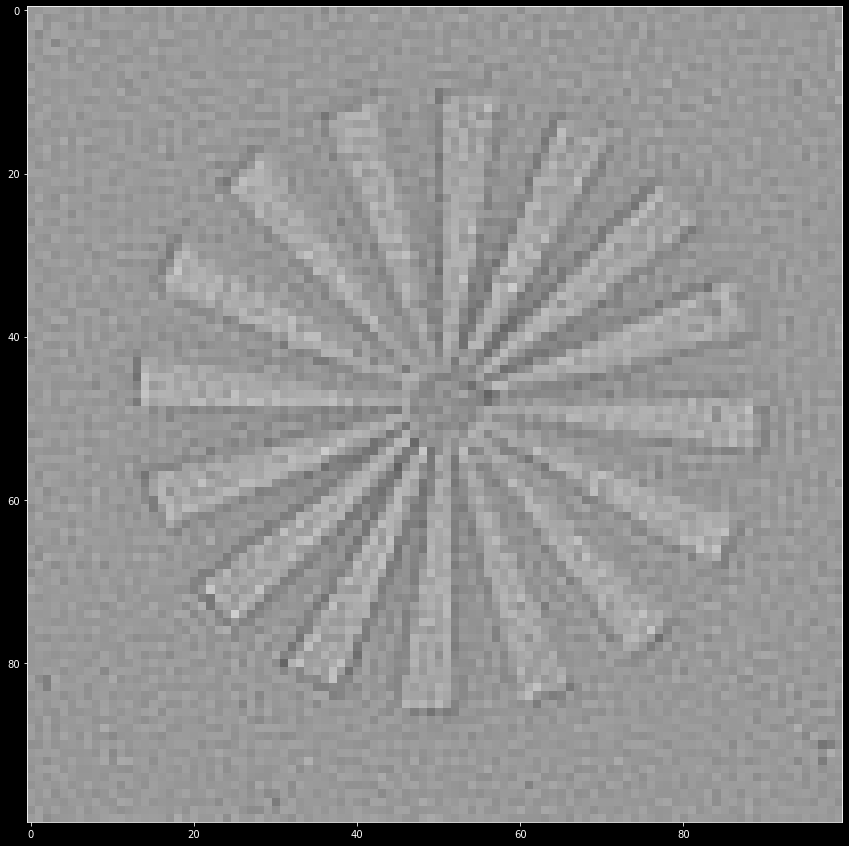

In [39]:
plt.figure(figsize=(15, 15))
plt.imshow(mu_sample_TV[105:205, 185:285], cmap="gray", clim=[-0.3, 0.2])

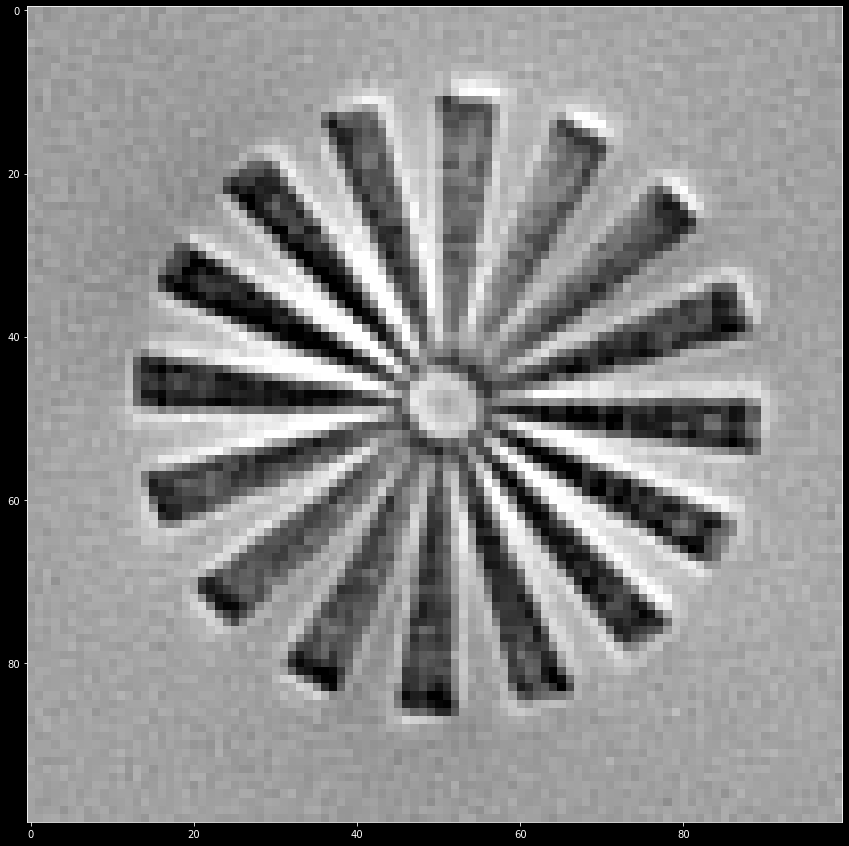

In [40]:
plt.figure(figsize=(15, 15))
plt.imshow(phi_sample_TV[105:205, 185:285], cmap="gray", clim=[-0.3, 0.2])

## Birefringence deconvolution with $S_1$ and $S_2$ 

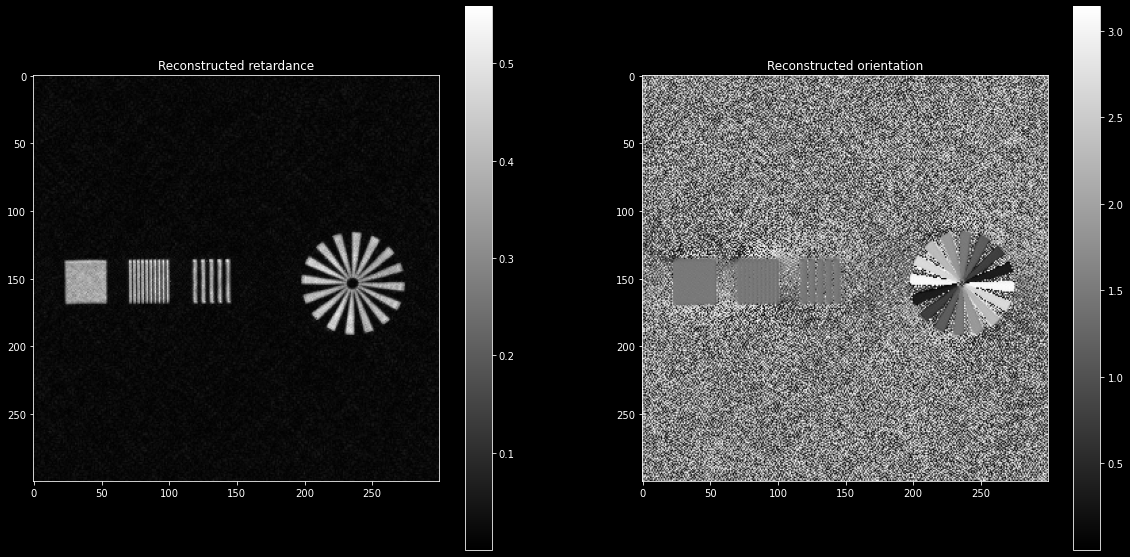

In [52]:
reg = 1e-3

# The negative sign on S2 here is to compensate the sign convention in the old data format
retardance_deconv, orientation_deconv = setup.Birefringence_recon_2D(S_image_tm[1], -S_image_tm[2], reg_br=reg)

wo.plot_multicolumn(
    np.array([retardance_deconv, orientation_deconv]),
    num_col=2,
    size=10,
    set_title=True,
    titles=["Reconstructed retardance", "Reconstructed orientation"],
)

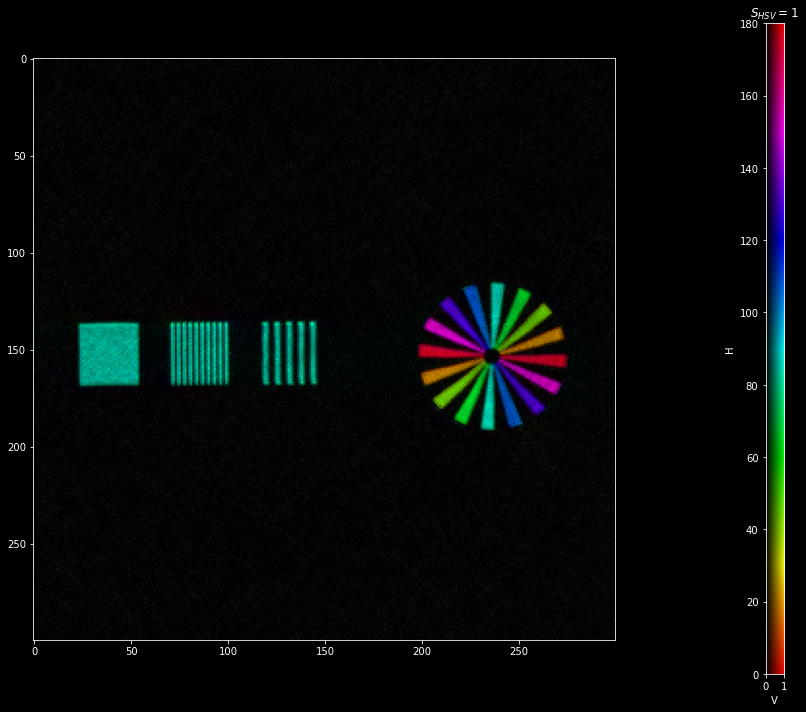

In [54]:
wo.plot_hsv([orientation_deconv, retardance_deconv], size=10)

## Line Plot verification

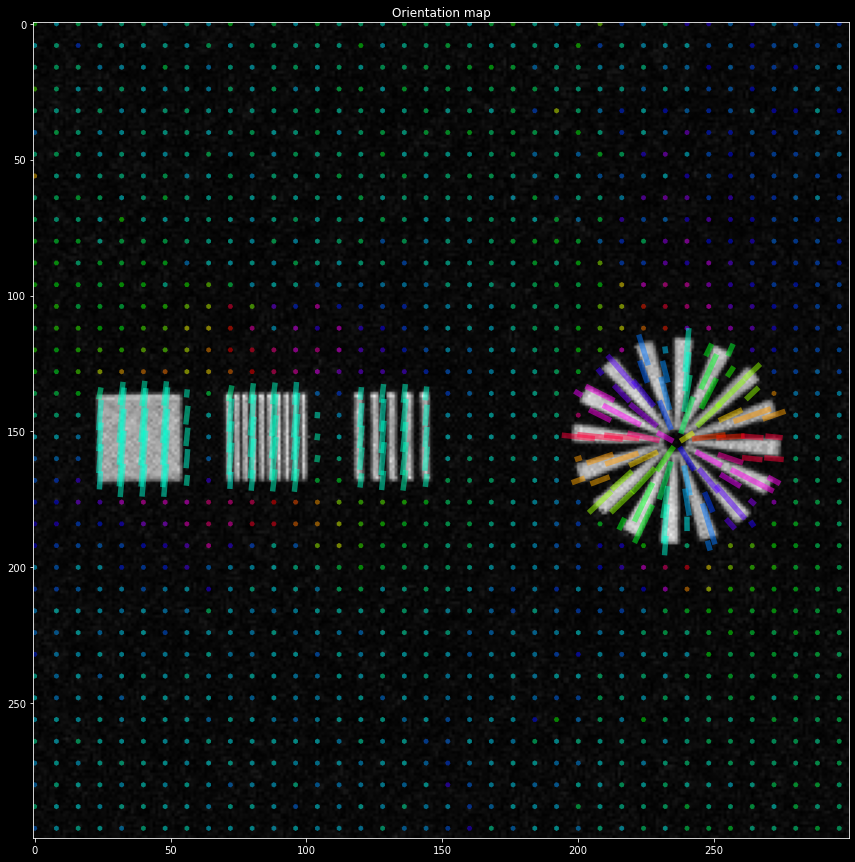

In [55]:
spacing = 8

plt.figure(figsize=(15, 15))
wo.plotVectorField(
    retardance_deconv,
    orientation_deconv,
    anisotropy=retardance_deconv / np.max(retardance_deconv) * 0.5,
    spacing=spacing,
    window=spacing,
    linelength=spacing,
    linewidth=2,
    linecolor="y",
    colorOrient=True,
    cmapOrient="hsv",
    threshold=None,
    alpha=0.5,
    clim=[None, None],
    cmapImage="gray",
)